In [3]:
import jupyterthemes as jt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
jt.jtplot.style(theme="monokai", context="notebook",grid=True,ticks=True)
if tf.config.list_physical_devices("GPU"):
    print("{}".format(tf.config.list_physical_devices("GPU")))
else:
    print("{}".format(tf.config.list_physical_devices("CPU")))

2021-07-03 14:50:01.502953: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-03 14:50:01.502989: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2021-07-03 14:50:02.893460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-03 14:50:02.893503: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-03 14:50:02.893543: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ws-5df6308e-cd66-4a47-bbe0-a8b09dbd6ec1): /proc/driver/

In [4]:
pd.read_csv("fulfilment_center_info.csv")

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6
...,...,...,...,...,...
72,53,590,56,TYPE_A,3.8
73,30,604,56,TYPE_A,3.5
74,76,614,85,TYPE_A,3.0
75,68,676,34,TYPE_B,4.1


In [91]:
pd.read_csv("meal_info.csv").head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [6]:
train_csv=pd.read_csv("train.csv")
train_csv


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729


<AxesSubplot:>

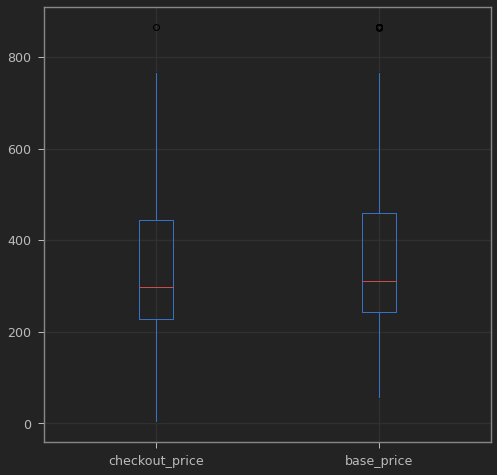

In [11]:
valueCounts=dict(train_csv["week"].value_counts().sort_index())
jt.jtplot.style(theme="monokai", context="notebook",grid=True,ticks=True)
train_csv.boxplot(column=["checkout_price","base_price"],figsize=(8,8))


In [12]:
checkout_price_outliers_index=train_csv[train_csv["checkout_price"]>800].index
train_csv.drop(checkout_price_outliers_index,inplace=True)
base_price_outliers_index=train_csv[train_csv["base_price"]>800].index
train_csv.drop(base_price_outliers_index,inplace=True)

<AxesSubplot:>

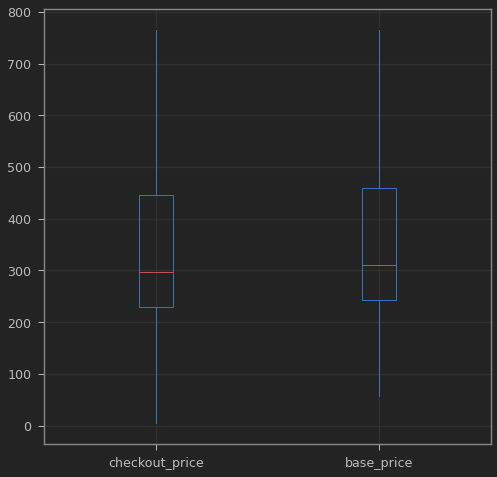

In [13]:
jt.jtplot.style(theme="monokai", context="notebook",grid=True,ticks=True)
train_csv.boxplot(column=["checkout_price","base_price"],figsize=(8,8))


In [14]:
#cross-verification of total unique meal ids w.r.t to meal ids in mail_info.csv
print(train_csv['meal_id'].unique())
print(train_csv['meal_id'].nunique())

[1885 1993 2539 2139 2631 1248 1778 1062 2707 1207 1230 2322 2290 1727
 1109 2640 2306 2126 2826 1754 1971 1902 1311 1803 1558 2581 1962 1445
 2444 2867 1525 2704 2304 2577 1878 1216 1247 1770 1198 1438 2494 1847
 2760 2492 1543 2664 2569 2490 1571 2956 2104]
51


In [15]:
#cross-verification of total unique center ids w.r.t to center ids in fulfilment_center.csv
print(train_csv['center_id'].unique())
print(train_csv['center_id'].nunique())

[ 55  24  11  83  32  13 109  52  93 186 146  57 149  89 124 152  97  74
 108  99  66  94  91  20  34 137  92 126  36 162  75 177  27 157 106  64
 129  14  17 153 139 161  81  26  73  50 104  42 113 145  53  72  67 174
  29  77  41  30  76  59  88 143  58  10 101  80  43  65  39 102 110 132
  23  86  68  51  61]
77


In [29]:
#df.head() loads only the top few rows instead of loading the complete dataset
train_csv.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [26]:
#to check if there are any NaN values in dataset.
train_csv["id"].nunique()
train_csv["emailer_for_promotion"].isnull().count()

456540

In [28]:
train_csv.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [45]:
#check to get an idea of how many orders are being placed per week 
print(train_csv[train_csv["week"]==1].count())
print(train_csv[train_csv["week"]==2].count())
print(train_csv[train_csv["week"]==3].count())


id                       2922
week                     2922
center_id                2922
meal_id                  2922
checkout_price           2922
base_price               2922
emailer_for_promotion    2922
homepage_featured        2922
num_orders               2922
dtype: int64
id                       2896
week                     2896
center_id                2896
meal_id                  2896
checkout_price           2896
base_price               2896
emailer_for_promotion    2896
homepage_featured        2896
num_orders               2896
dtype: int64
id                       2899
week                     2899
center_id                2899
meal_id                  2899
checkout_price           2899
base_price               2899
emailer_for_promotion    2899
homepage_featured        2899
num_orders               2899
dtype: int64


### There are almost close to 3000 diiferent id's ordering per week. Order id's will stay unique even if it is given by the same person. Which means that there are approx 3000 people ordering every week.




### To check the number of orders per week and their frequency, lets plot graphs per week.

#  3-WEEK DATA ANALYSIS
### It can be hard to analyze 145 weeks with almost 3000 unique orders per week. So,  here is a scatter plot of first three weeks of data.
<img src="images/fulfilment_center/main/3-week.png">



# Single Week Data Analysis
### The above plots may seem very much confusing, so lets see a single week data to get a better idea.
<img src="images/fulfilment_center/main/week2.png">

### It is a time series graph with crazy number of orders and respective quantities to visualize. { But for training a model, it's decent amount of data :) }


## The below two cells give you the code behind these graphs

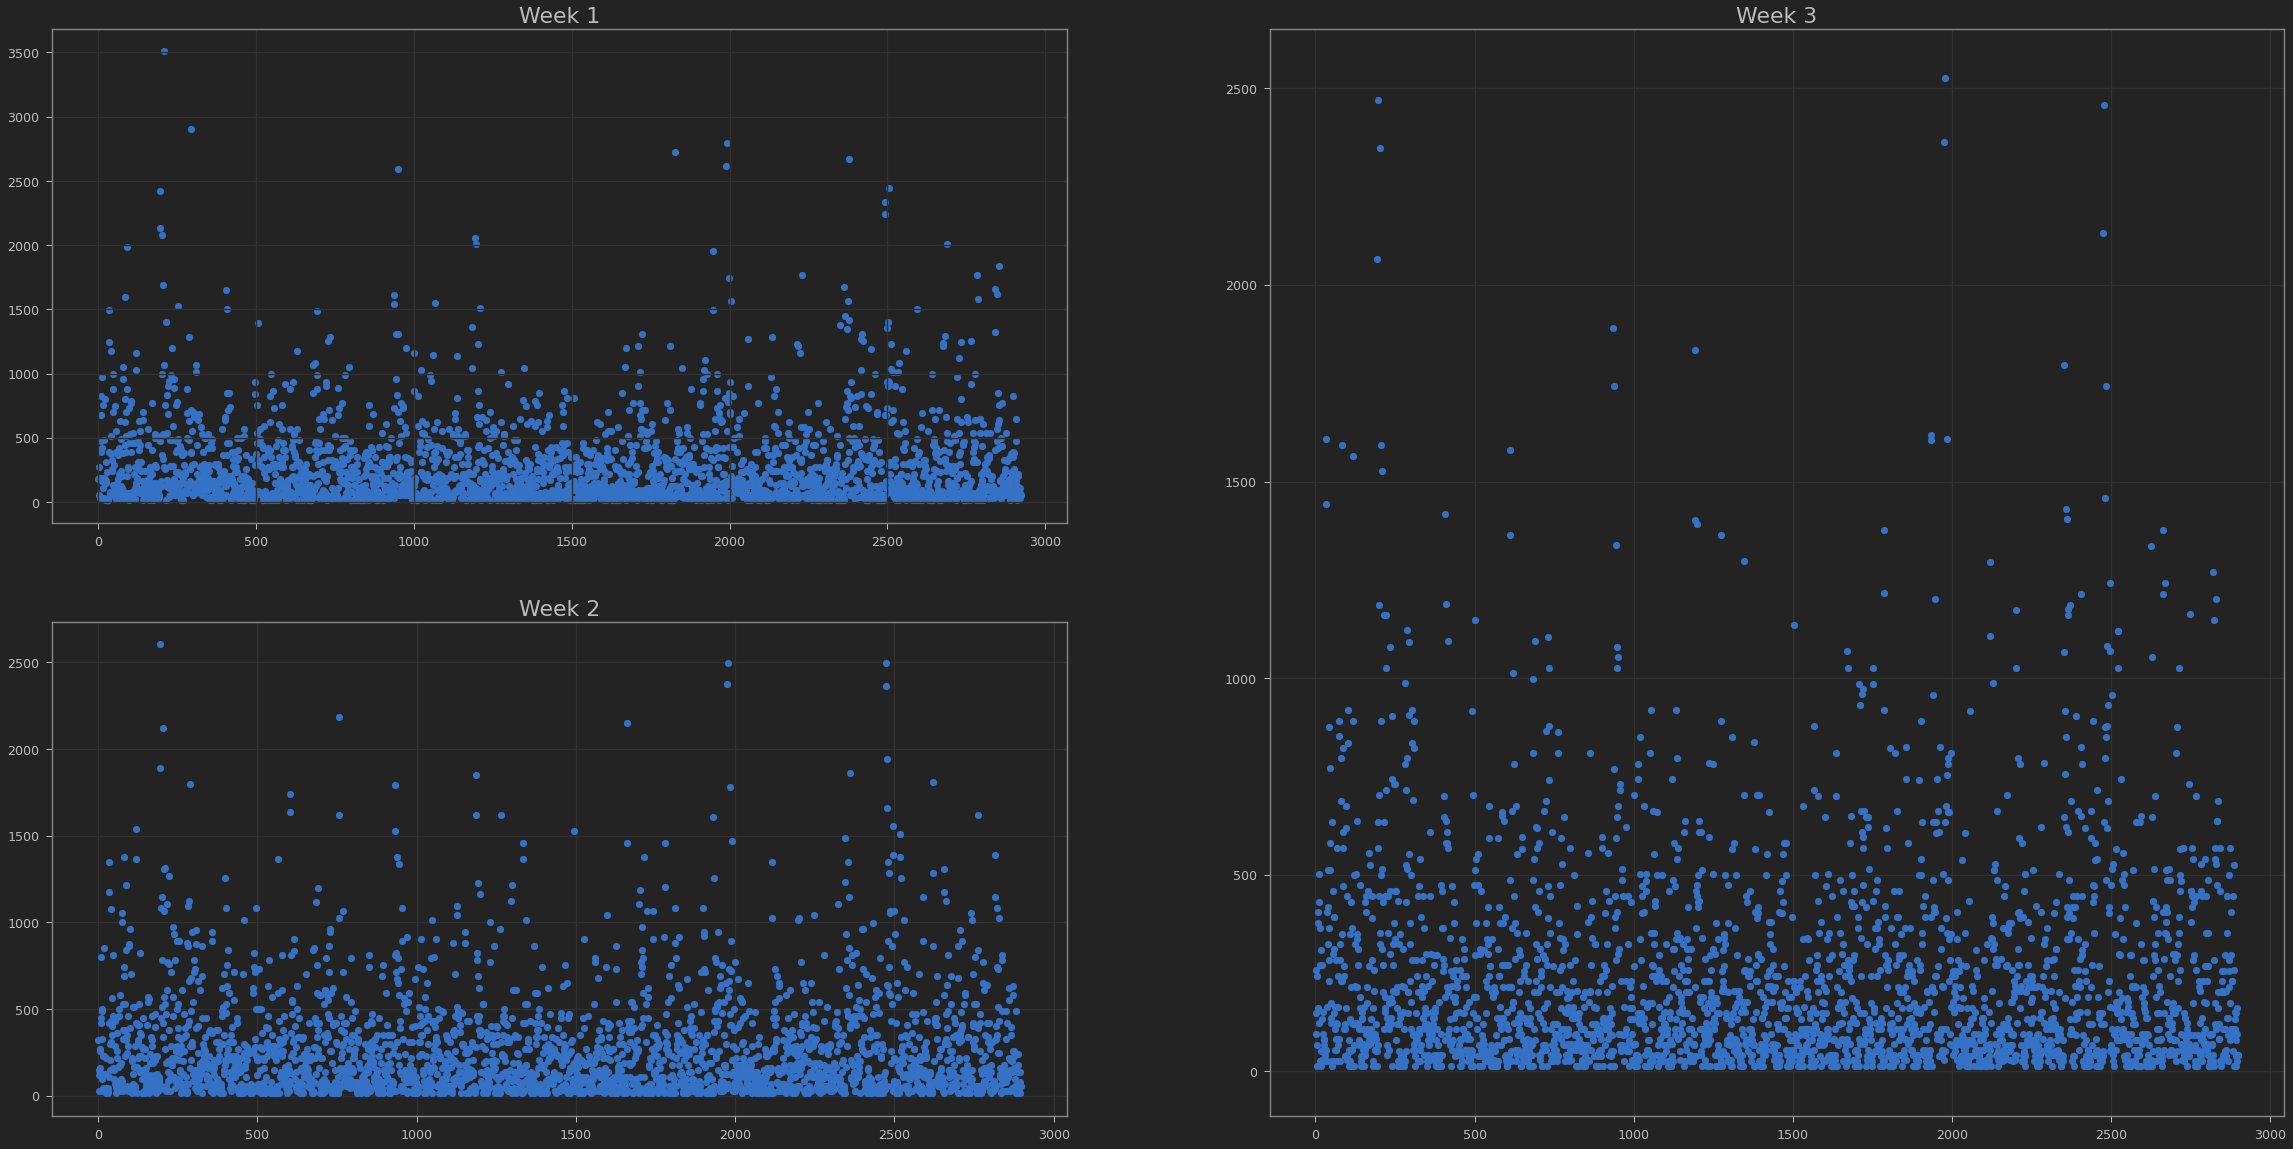

In [90]:
jt.jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)  #more better veiwing of plots.Use it with visual studio dark theme to see the beauty!
plt.figure(figsize=(40,20))
gridsize=(2,2)
plot1=plt.subplot2grid(gridsize, (0,0))
plot2=plt.subplot2grid(gridsize, (1,0))
plot3=plt.subplot2grid(gridsize, (0,1), colspan=1, rowspan=2)

count=0
x_plot1=[]
for id in range(1,train_csv["id"][train_csv["week"]==1].count()+1):
    count+=1
    x_plot1.append(count)
count=0
x_plot2=[]
for id in range(1,train_csv["id"][train_csv["week"]==2].count()+1):
    count+=1
    x_plot2.append(count)

count=0
x_plot3=[]
for id in range(1,train_csv["id"][train_csv["week"]==3].count()+1):
    count+=1
    x_plot3.append(count)

y_plot1=train_csv["num_orders"][train_csv["week"]==1]

y_plot2=train_csv["num_orders"][train_csv["week"]==2]

y_plot3=train_csv["num_orders"][train_csv["week"]==3]

plt.title(" First three weeks data analysis")
plot1.set_title(" Week 1 ", fontsize=22)  #added fontsize
plot1.scatter(x_plot1, y_plot1)
plot2.set_title(" Week 2 ", fontsize=22)  #added fontsize
plot2.scatter(x_plot2, y_plot2, zorder=2)  #zorder helps in overlaying data on gridlines
plot2.grid(zorder=1)  #zorder helps in overlaying data on gridlines
plot3.set_title(" Week 3 ", fontsize=22)  #added fontsize
plot3.grid(zorder=1)  #zorder helps in overlaying data on gridlines
plot3.scatter(x_plot3, y_plot3, zorder=2) #zorder helps in overlaying data on gridlines
plt.show()

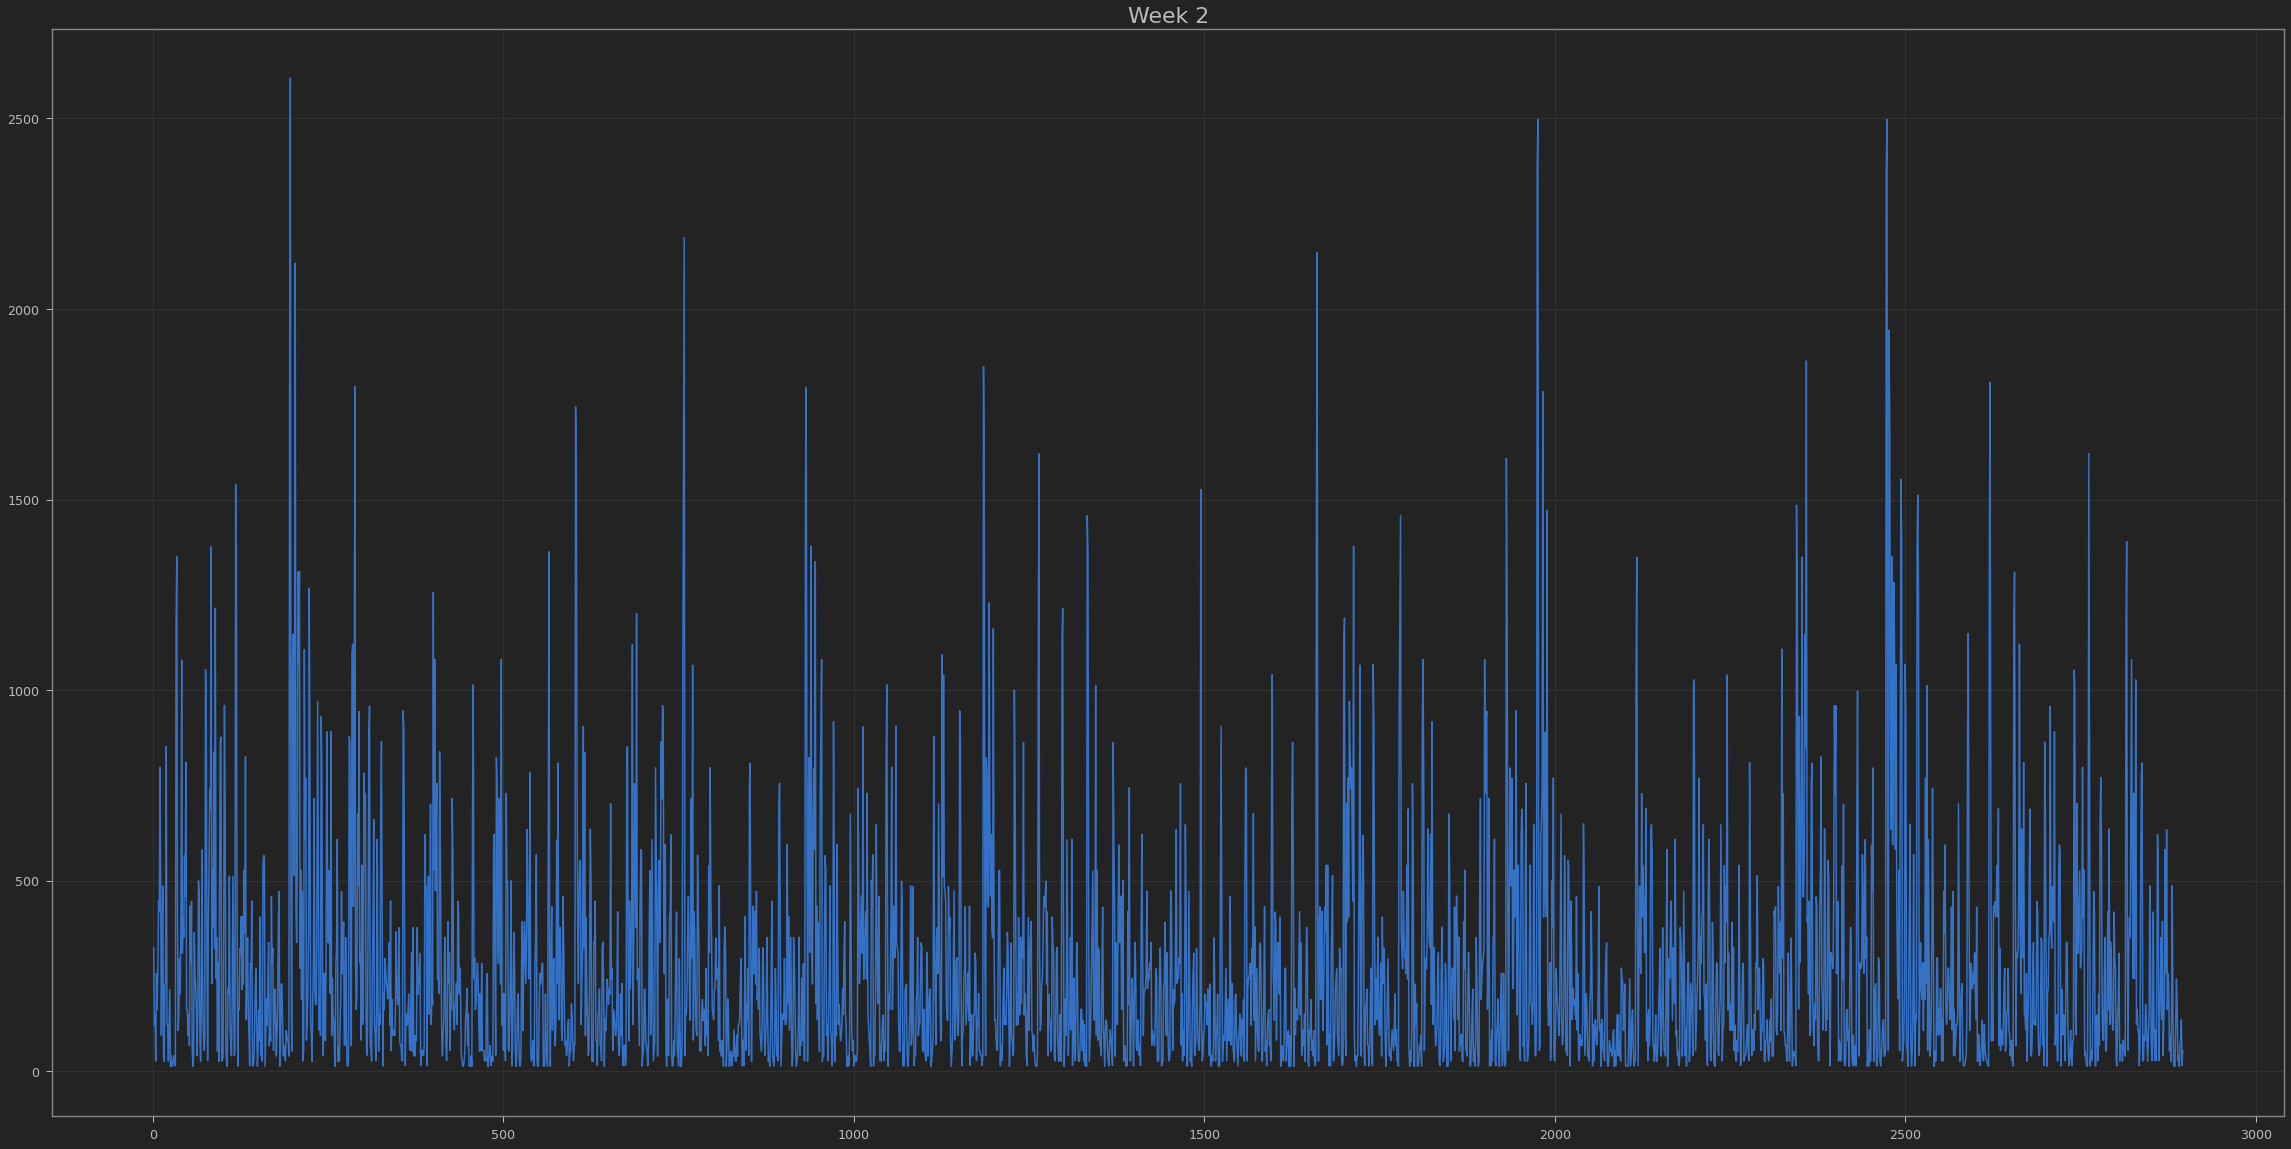

In [86]:
count=0
x_plot2=[]
for head_number in range(1,train_csv["id"][train_csv["week"]==2].count()+1):
    count+=1
    x_plot2.append(count)
y_plot2=train_csv["num_orders"][train_csv["week"]==2]

plt.figure(figsize=(40,20))
plt.title(" Week 2 ", fontsize=22)  #added fontsize
#plt.scatter(x_plot2, y_plot2)
plt.plot(x_plot2, y_plot2, zorder=2)  #zorder helps in overlaying data on gridlines
#plt.grid(zorder=1)  #zorder helps in overlaying data on gridlines
plt.show()

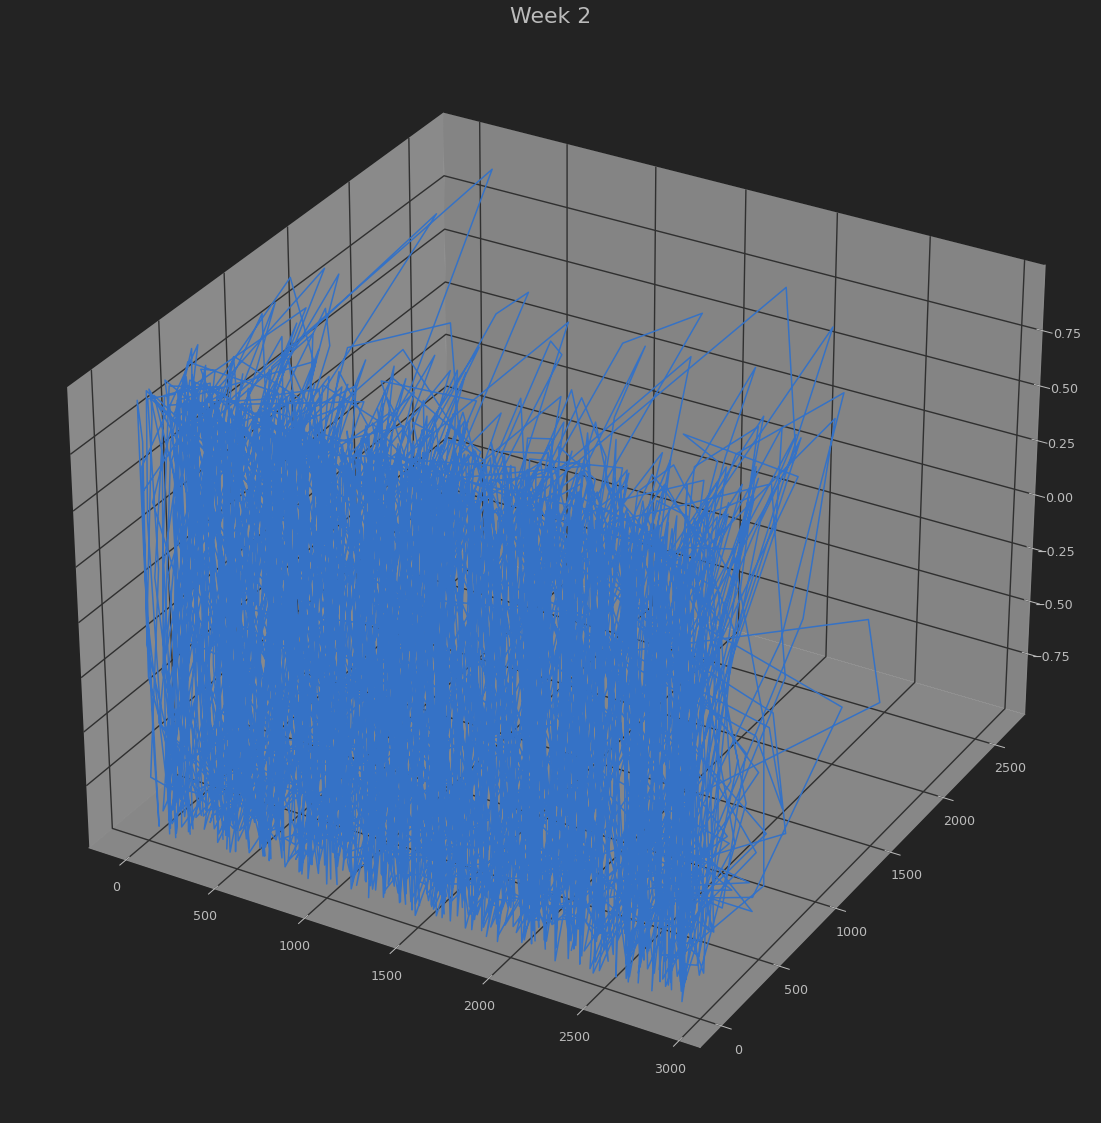

In [99]:
# count=0
# x_plot2=[]
# for head_number in range(1,train_csv["id"][train_csv["week"]==2].count()+1):
#     count+=1
#     x_plot2.append(count)
# y_plot2=train_csv["num_orders"][train_csv["week"]==2]
# z_plot2=np.sin(x_plot2)
# fig=plt.figure(figsize=(40,20))
# plot=fig.gca(projection='3d')
# plt.title(" Week 2 ", fontsize=22)  #added fontsize
# #plt.scatter(x_plot2, y_plot2)
# plt.plot(x_plot2, y_plot2, z_plot2,zorder=2)  #zorder helps in overlaying data on gridlines
# #plt.grid(zorder=1)  #zorder helps in overlaying data on gridlines
# plt.show()

In [98]:
train_csv["num_orders"].nunique()

1250